In [86]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
sys.path.append("../utils")
from utils import load_data

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.neural_network import MLPRegressor
import shap
from pathlib import Path

In [87]:
# Load the data 
data_train, data_test , targets= load_data(raw=False)
_,_, targets_train = load_data(raw=True)

In [40]:
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' 
cgc_file = pd.read_csv(data_path / 'CGC.csv')

# Create the CGC array 
cgc_genes = cgc_file['Gene Symbol']

# Extract CGC genes
cgc_genes = np.array(cgc_genes)  # Convert to numpy array

In [92]:
# Filtring our dataset, deleting all the genes not present in the cgc_genes dataset
gene_train  = set(data_train.columns)
filtered_data_train = data_train.loc[:, data_train.columns.intersection(cgc_genes)]
print (filtered_data_train.shape)

(742, 735)


In [107]:
tissue_types = targets_train['tissue'].str.strip().unique()
print (tissue_types)


['Prostate' 'Esophagus/Stomach' 'Bladder/Urinary Tract' 'CNS/Brain'
 'Lymphoid' 'Kidney' 'Thyroid' 'Soft Tissue' 'Skin' 'Lung' 'Bone'
 'Ovary/Fallopian Tube' 'Pleura' 'Myeloid' 'Uterus' 'Pancreas' 'Breast'
 'Head and Neck' 'Bowel' 'Peripheral Nervous System' 'Cervix' 'Liver'
 'Biliary Tract' 'Other' 'Ampulla of Vater']


In [135]:
# Placeholder for results
results = []

# Step 1: Extract unique tissue types from targets_train
tissue_types = targets_train['tissue'].str.strip().unique()

for tissue in tissue_types:

    # Filter rows in targets_train for the current tissue type
    filtred_target_tissue = targets_train[targets_train['tissue'].str.contains(tissue, case=False, na=False)]
    
    # Get the indices of these rows
    tissue_indices = filtred_target_tissue.index
    
    # Filter rows in train_target based on these indices
    filtered_train_tissue = filtered_data_train.iloc[tissue_indices]

    # Prepare feature matrix X and target vector Y
    X = filtered_train_tissue
    Y = filtred_target_tissue['AAC']
    
    # Number of samples for the tissue
    num_samples = len(X)
    
    # Check the size of the dataset
    if num_samples < 2:
        # Skip tissues with less than 2 samples
        print(f"Skipping tissue '{tissue}' due to insufficient data (n={num_samples}).")
        continue
    
    if num_samples >=30:
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
        
        # Train a Random Forest model
        random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
        random_forest.fit(X_train, y_train)
        
        # Predict on validation data
        y_val_pred = random_forest.predict(X_val)
        
        # Evaluate the model
        mse = mean_squared_error(y_val, y_val_pred)
        spearman_corr, p_value = spearmanr(y_val, y_val_pred)
        

        # Store the results for this tissue type
        results.append({
            'Tissue': tissue,
            'Number of Samples': num_samples,
            'MSE': mse,
            "Spearman's Correlation": spearman_corr
        })
    

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

print(results_df) 


Skipping tissue 'Cervix' due to insufficient data (n=1).
                  Tissue  Number of Samples       MSE  Spearman's Correlation
0      Esophagus/Stomach                 54  0.005973                0.118182
1              CNS/Brain                 45  0.000992                0.400000
2               Lymphoid                 93  0.004180                0.514035
3                   Skin                 48  0.002027                0.272727
4                   Lung                128  0.011013                0.386391
5   Ovary/Fallopian Tube                 37  0.006338               -0.380952
6                Myeloid                 39  0.006406                0.738095
7               Pancreas                 36  0.004582               -0.476190
8                 Breast                 33  0.001850                0.678571
9          Head and Neck                 30  0.004953                0.714286
10                 Bowel                 39  0.007700                0.238095


shap_values shape: (6, 735)


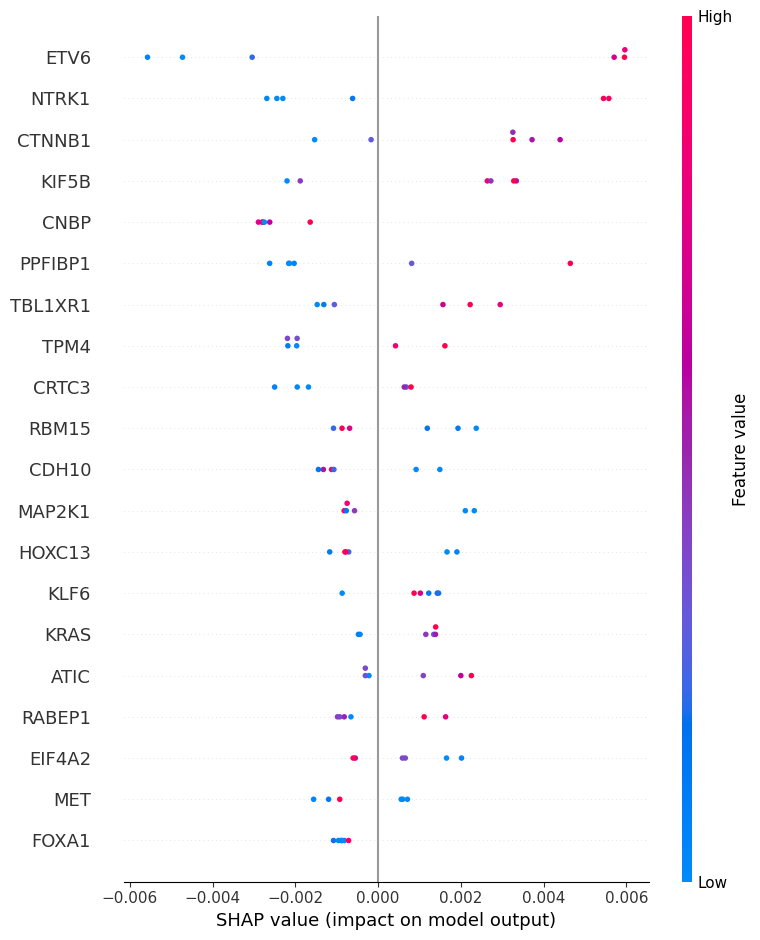

shap_values shape: (6, 735)


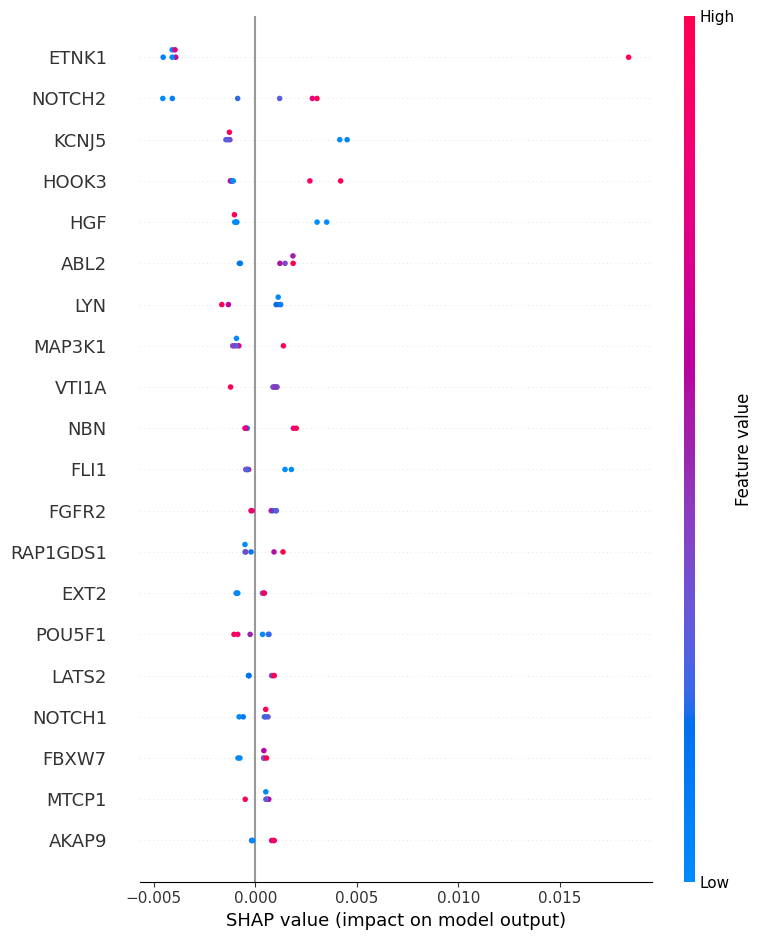

shap_values shape: (6, 735)


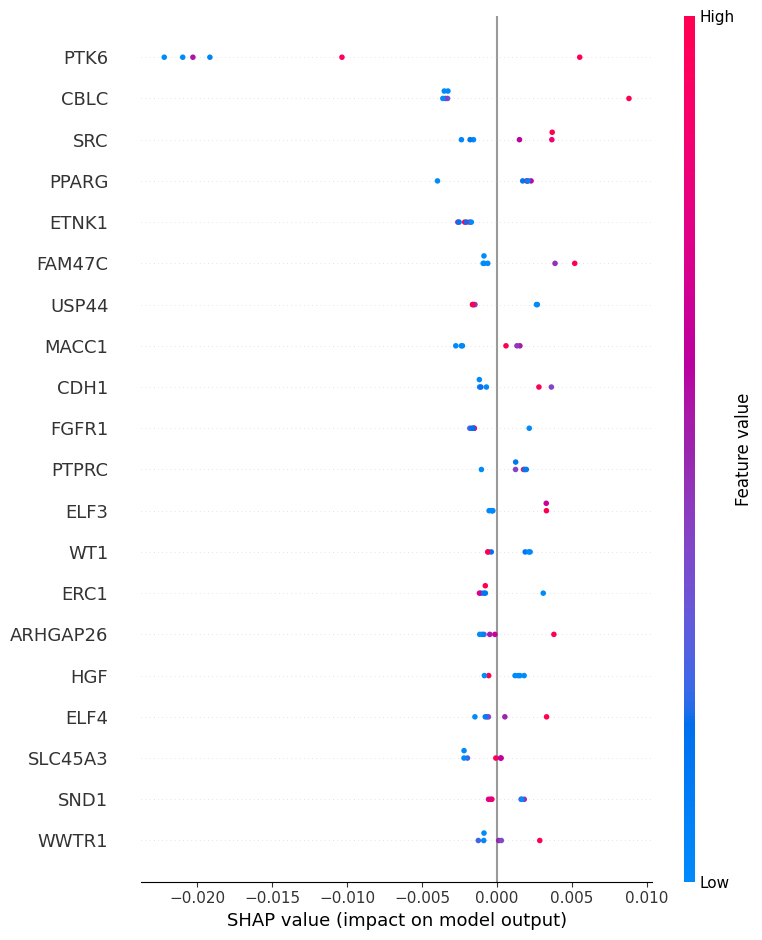

shap_values shape: (6, 735)


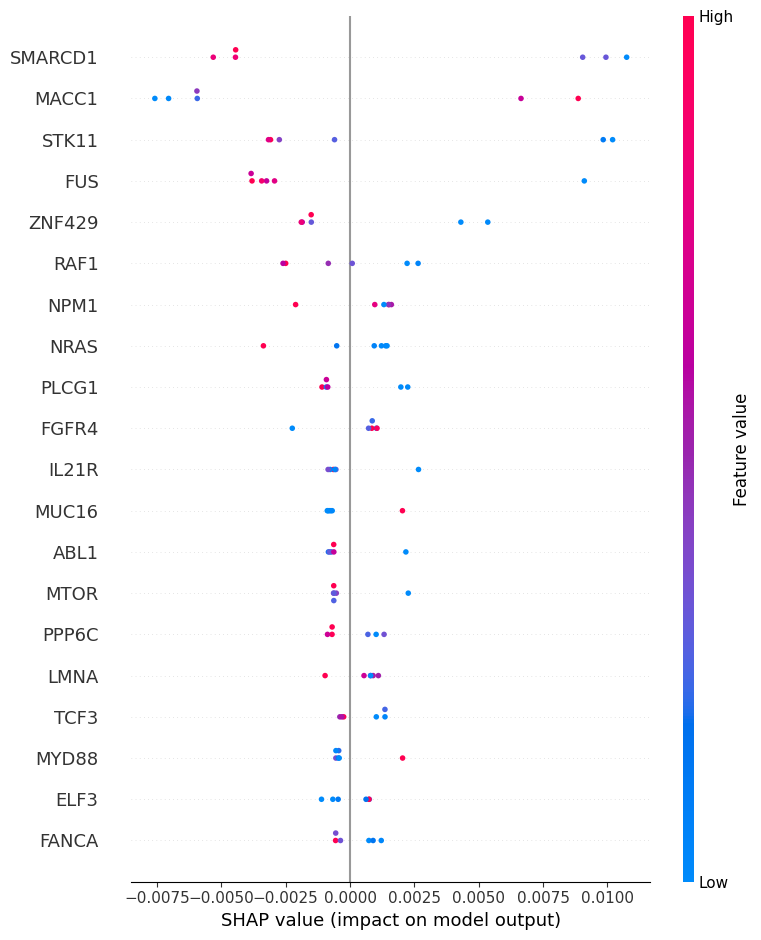

                 Tissue  Number of Samples       MSE  Spearman's Correlation
0     Esophagus/Stomach                 30  0.006475               -0.028571
1             CNS/Brain                 30  0.001717               -0.085714
2              Lymphoid                 30  0.004304                0.771429
3                  Skin                 30  0.000995                0.885714
4                  Lung                 30  0.003902                0.753702
5  Ovary/Fallopian Tube                 30  0.009595               -0.142857
6               Myeloid                 30  0.003995                0.142857
7              Pancreas                 30  0.018911               -0.371429
8                Breast                 30  0.005339                0.771429
9                 Bowel                 30  0.014101                0.371429


In [82]:
# Placeholder for results
results_subset = []

# Step 1: Filter tissues with more than 30 samples
tissues_with_enough_samples = [tissue for tissue in tissue_types if len(targets_train[targets_train['tissue'].str.contains(tissue, case=False, na=False)]) > 30]

for tissue in tissues_with_enough_samples:
    # Filter rows in targets_train for the current tissue type
    tissue_targets = targets_train[targets_train['tissue'].str.contains(tissue, case=False, na=False)]
    
    # Get the indices of these rows
    tissue_indices = tissue_targets.index
    
    # Filter rows in data_train based on these indices
    tissue_matrix = data_train.iloc[tissue_indices]
    
    # Randomly select 30 samples from this tissue
    sampled_indices = tissue_targets.sample(n=30, random_state=42).index
    sampled_tissue_matrix = data_train.loc[sampled_indices]
    sampled_tissue_targets = targets_train.loc[sampled_indices]
    
    # Extract the gene names (columns) from the tissue-specific data
    gene_columns = set(sampled_tissue_matrix.columns)
    
    # Find common genes between CGC genes and tissue-specific dataset genes
    common_genes = list(set(cgc_genes) & gene_columns)
    
    if not common_genes:
        # Skip if no common genes
        continue

    # Filter the tissue_matrix to include only the common genes
    filtered_tissue_matrix = sampled_tissue_matrix[common_genes]
    
    # Prepare feature matrix X and target vector Y
    X = filtered_tissue_matrix
    Y = sampled_tissue_targets["AAC"]
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Train a Random Forest model
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest.fit(X_train, y_train)
    
    # Predict on validation data
    y_val_pred = random_forest.predict(X_val)

    # Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    spearman_corr, p_value = spearmanr(y_val, y_val_pred)

    if spearman_corr > 0.70: 

            # Create SHAP explainer
        explainer = shap.TreeExplainer(random_forest)

        # Calculate SHAP values for the validation set
        shap_values = explainer.shap_values(X_val)

        # Check the shape of shap_values
        print(f"shap_values shape: {np.array(shap_values).shape}")

        # If it's a binary classification
        if isinstance(shap_values, list) and len(shap_values) == 2:  # Binary case with probabilities
            shap_values_to_plot = shap_values[1]  # Focus on the positive class
        else:
            shap_values_to_plot = shap_values  # Single output case

        # Visualize global feature importance
        shap.summary_plot(shap_values_to_plot, X_val)
        
    
    # Store the results for this tissue type
    results_subset.append({
        'Tissue': tissue,
        'Number of Samples': 30,  # Fixed to 30 as per sampling
        'MSE': mse,
        "Spearman's Correlation": spearman_corr
    })

# Convert results to a DataFrame for better visualization
results_subset_df = pd.DataFrame(results_subset)

print(results_subset_df)


In [ ]:
# Train Linear Regression model 
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
spearman_non_encoded, p_value_non_encoded = spearmanr(y_val, y_val_pred)

print("--- Non Encoded Features ---")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Spearman's Correlation (ρ):", spearman_non_encoded)
print("P-value (Spearman):", p_value_non_encoded)

In [ ]:
# Train an MLP model
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)

print (X_train)
mlp_model.fit(X_train, y_train)

# Predict on validation data

y_val_pred = mlp_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
spearman_non_encoded, p_value_non_encoded = spearmanr(y_val, y_val_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Spearman's Correlation (ρ):", spearman_non_encoded)
print("P-value (Spearman):", p_value_non_encoded)